# Converter Program for Circuit model to MBQC 

In [1]:
from qiskit import *
from qiskit.quantum_info.synthesis.one_qubit_decompose import OneQubitEulerDecomposer
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere, plot_histogram
import numpy as np
from math import pi
import math
import cmath
from cmath import polar, acos
from qiskit import quantum_info as qi
from qiskit.circuit.library import *
from qiskit.quantum_info import Operator
import matplotlib as mpl
import time

### Instructions:<br>

**Input format**: QASM file.<br>

**Output format**: 3 numpy arrays - parameters, CZ controls, CZ targets matrices that can be supplied as inputs to the MBQC Simulator<br>

**Best Practices**:

* It is suggested that you build the circuit using IBM Qiskit and then use the circuit.qasm(filename) function to generate the QASM file input for the converter<br><br>

* The converter supports only single qubit unitary gates U and 2 qubit controlled unitary gates CU. If your circuit has any multi-qubit gates other than 2 qubit controlled unitaries, please use the circuit.decompose() method and then generate the QASM file from the decomposed circuit. You can use the decompose method multiple times, until the final circuit has only the gates supported by the converter.<br><br>

* For large circuits where drawing the circuit and identifying unsupported gates and decomposing them might not possible. In that case it is recommended that you transpile the circuit to a basis gate set like ['rz','h','cz'].<br><br>

* The converter performs some optimization. To prevent optimization across a boundary or to preserve the different parts of an algorithm in the circuit, use barriers. Just like qiskit, optimization is done before and after the barrier but not across the barrier.<br><br>

* The QASM file should only have a simple and straightforward circuit definition. Ensure that your QASM file does not have any functions. If you use arbitrary single qubit gates U or 2 qubit controlled unitaries CU, the converter will ask for the unitary matrix of the single qubit gate U(for controlled unitaries - CU also). Please do not provide their unitaries or other gate definitions in the QASM file

In [2]:
# class containing operations performed based on the gate or related to gates
class Gate:
    
    # function to convert single qubit unitary U to SU(2)
    def to_SU2(self, U):
        det = np.linalg.det(U)
        gfactor = cmath.sqrt(det)

        # scale the values in U so that determinant is 1(yielding an SU(2) matrix)
        g = np.asarray(U)*1/gfactor
        return g

    # function that finds the Euler angles of an arbitrary single qubit unitary U
    # Formulas and idea taken from: http://nlab-pages.s3.us-east-2.amazonaws.com/nlab/show/Euler+angle#construction_for_
    def euler_angles(self, U):
        g = self.to_SU2(U)

        mod_a = polar(g[0][0])[0] # finding |a| of complex number a
        arg_a = polar(g[0][0])[1] # finding argument arg(a) of complex number a 
        arg_b = polar(g[0][1])[1] # finding argument arg(b) of complex number b 

        # finding the angles
        theta = 2*acos(mod_a).real
        phi = (arg_a + arg_b - pi/2)
        psi = (arg_a - arg_b + pi/2)

        return [-psi, -theta, -phi]
    
    # function to read the value between 'left' and 'right' characters given as input
    # Example: if left = '[' and right = ']' then we read the value within '[]' like size of array in qreg q[5] or 
    # qubit index in 'h q[0]' and if left = '[' and right = ',' we read the angle for rotation gates like 'rz(-pi/2, 0)'
    def get_value_between(self, instruction, left, right):
        start = instruction.find(left)
        stop = instruction.find(right, start+1)

        # if it is an expression or integer, then get the numerical value from the string using eval function
        # for instance if the value is '1'(string type), eval returns integer 1
        # if the value is '-pi/2'(string type), eval returns the floating point value of -pi/2
        try:
            val = eval(instruction[start+1:stop])
        except:
            val = instruction[start+1:stop]

        return val
    
    # function to return the unitary matrix of single qubit gates
    def get_single_qubit_gate_unitary(self, gate):

        # a dictionary mapping the non-parameterized Gate names with the respective Qiskit gate object
        # all the gates are taken from Qiskit's OPENQASM gate set  
        non_parameterized_gate_map = {'h': HGate(), 'x': XGate(), 'y': YGate(), 'z': ZGate(), 't': TGate(), 'tdg': TdgGate(), 
                   's': SGate(), 'sdg': SdgGate()}

        # handling non-parameterized single qubit gates
        if gate in non_parameterized_gate_map:
            U = Operator(non_parameterized_gate_map[gate]).data
            return U

        # handle parameterized single qubit gates of the type U()
        left_paran = gate.find('(')
        gate_name = gate[:left_paran] # get the gate name alone, excluding the parameters

        # gate with a single parameter
        if gate_name in ['p','rx','ry','rz','u1']:
            angle = self.get_value_between(gate, '(', ',')
            # to account for angles that are represented like -pi/2 (not a number)
            
            # to remove the gate label(if any) from the parameters
            if type(angle) is tuple:
                angle = angle[0]

            parameterized_gate_map = {'p': PhaseGate(angle), 'rx': RXGate(angle), 'ry': RYGate(angle), 'rz': RZGate(angle), 
                                      'u1': U1Gate(angle)}

            U = Operator(parameterized_gate_map[gate_name]).data

        # gate with 2 parameters
        elif gate[0:2] == 'u2':
            angle1 = self.get_value_between(gate, '(', ',')
            angle2 = self.get_value_between(gate, ',', ')')
            
            # to remove the gate label(if any) from the parameters
            if type(angle2) is tuple:
                angle2 = angle2[0]
                
            U = Operator(U2Gate(angle1, angle2)).data

        # gate with 3 parameters. General form is U3(angle1, angle2, angle3)
        elif gate[0:2] == 'u3' or gate[0] == 'u':
            angle1 = self.get_value_between(gate, '(', ',')
            angles = self.get_value_between(gate, ',', ')') # returns a tuple (angle2, angle3) or (angle2, angle3, label)
            
            # to remove the gate label(if any) from the parameters
            angle2, angle3 = angles[0], angles[1]
                
            #display(print(angle1, angle2, angle3))
            U = Operator(U3Gate(angle1, angle2, angle3)).data
            

        # get the unitary from the user, if it is an unknown gate
        else:
            U = np.array([[],[]])
            print("Enter the unitary for", gate)
            for i in range(3):
                t = complex(input("Element {0:2b}".format(i)))
                U[i/2].append(t)         
            print()

        return U
    
    # # check if a gate is a parameterized gate
    # def parameterized(self, gate):
    #     left_paran = gate.find('(')
    #     right_paran = gate.find(')')
    #     for left_paran != -1 and right_paran != -1:  # gate is like Rz(), P() implies it is parameterized
    #         return True

    #     return False

    # # check if a gate has multiple parameters separated by a gate
    # def comma_in_gate_parameters(self, gate):
    #     comma = gate.find(',')
    #     if comma == -1:
    #         return False

    #     return True
    
    
    # find the MBQC parameters of a 2-qubit controlled unitary CU
    # The basic idea is that the single qubit unitary U corresponding to the CU gate can be expressed as 
    # U=e^iα AXBXC where ABC = I and using Euler angles of U, we find A, B and C. 
    # CU operation then corresponds to applying A.Cnot.B.Cnot.C on target qubit and P(α) on control qubit
    # We decompose Cnot to H.Cz.H, so the gates applied on target qubit are A.H.Cz.H.B.H.Cz.H.C (dots are used only for better understanding)
    # Refer the 10th Anniversary edition of Quantum Computation and Quantum Information by Nielsen and Chuang,
    # Chapter 4 Pg: 176, 181 for the method
    def controlled_unitary_MBQC_parameters(self, U, distance):
        angles = [[], []]
        czc = [[], []]
        czt = [[], []]

        #find Euler angles and phase angle of the unitary U
        gamma, beta, delta, alpha = OneQubitEulerDecomposer(basis='ZYZ').angles_and_phase(U)
        # print(alpha, beta, gamma, delta)

        #find unitary matrix of AH where A = Rz(β)Ry(γ/2)

        qc = QuantumCircuit(1)
        qc.h(0)
        qc.ry(gamma/2,0)
        qc.rz(beta, 0)
        A = execute(qc, Aer.get_backend('unitary_simulator')).result().get_unitary().data

        #Euler angles of AH
        anglesA = self.euler_angles(A)
        anglesA.append(0)

        #find unitary matrix of HBH, where B = Ry(-γ/2)Rz(-(δ+β)/2)

        qc = QuantumCircuit(1)
        qc.h(0)
        qc.rz(-(delta+beta)/2,0)
        qc.ry(-gamma/2, 0)
        qc.h(0)
        B = execute(qc, Aer.get_backend('unitary_simulator')).result().get_unitary().data

        #Euler angles of HBH
        anglesB = self.euler_angles(B)
        anglesB.append(0)

        # find unitary matrix of HC, where C = Rz((δ-β)/2)
        qc = QuantumCircuit(1)
        qc.rz((delta-beta)/2,0)
        qc.h(0)
        C = execute(qc, Aer.get_backend('unitary_simulator')).result().get_unitary().data

        #Euler angles of HC
        anglesC = self.euler_angles(C)
        anglesC.append(0)

        #Euler angles of R(alpha)(equivalent to Qiskit's P(Phase) gate) which is applied on the control qubit
        Ralpha = Operator(PhaseGate(alpha)).data
        anglesR = self.euler_angles(Ralpha)
        anglesR.append(0)

        # Combine the euler angles in the correct order of execution
        angles[0] += [0,0,0,0] 
        angles[1] += anglesC
        czc[0] += [0,0,0,0] 
        czt[0] += [0,0,0,0] 

        czc[0] += [1]
        czt[0] += [[distance]]

        angles[0] += [0,0,0,0]
        angles[1] += anglesB
        czc[0] += [0,0,0]
        czt[0] += [0,0,0]

        czc[0] += [1]
        czt[0] += [[distance]]

        angles[0] += anglesR
        angles[1] += anglesA

        czc[0] += [0,0,0]
        czt[0] += [0,0,0]

        czc[1] += [0]*len(czc[0])
        czt[1] += [0]*len(czc[0])

        return angles, czc, czt
    

# class dealing with individual instructions from the QASM file
class Instruction(Gate):
    
    # decode instruction and return True if the instruction is incorporated in the MBQC model   
    def parse_instruction(self, instruction, single_qubit_unitary, control_unitary, control_unitary_controls, control_unitary_targets, cu_seen, barrier_seen):

        space = instruction.find(' ')
        gate = instruction[:space] # get the gate name from the instruction

        if gate == "barrier":
            # print("Barrier start")

            # mark barrier_seen as true for all the qubits across which barrier is drawn. 
            # This stops further optimization on the qubits which have a barrier
            comma = 0 # we will have to execute the loop atleast once because a barrier is drawn on atleast 1 qubit
            inst = instruction # a copy of the instruction that we will manipulate instead of modifying the original instruction
            while comma != -1:
                # print(inst, comma)

                qubit = super().get_value_between(inst, '[', ']')
                barrier_seen[qubit] = True
                comma = inst.find(',')
                if comma!=-1:
                    inst = inst[comma+1:]

            # print("Barrier end")
            return True

        # 2 qubit gate

        # check that comma is used to indicate multiple qubits and not multiple parameters of a parameterized single qubit gate
        comma = instruction.find(',', space+1)

        if comma != -1:

            gate = gate[1:] # remove the 'C' from CU for easier gate recognition because U is just a single qubit gate

            # find the control and target qubits
            control = super().get_value_between(instruction, '[', ']')
            inst = instruction[comma+1:]
            target = super().get_value_between(inst, '[', ']')

            if cu_seen[control] or cu_seen[target] or barrier_seen[control] or barrier_seen[target]:
                # we have seen a 2 qubit gate or a barrier is drawn on these qubits already
                # so we set CU_seen as True because we cannot execute any gates after this CU operation 
                # before processing this CU gate
                cu_seen[control] = True
                cu_seen[target] = True

                # Extra optimization(not required): np.dot here if control, target are same as the last CU operation on control and target qubits

                return False

            # we have seen a 2 qubit gate now and no CU operation was encountered just before this
            # so we should not process any gates after this
            cu_seen[control] = True
            cu_seen[target] = True

            U = super().get_single_qubit_gate_unitary(gate) # get the unitary matrix

            # We have already removed the 'C' from 'CU'. So if gate was CZ, the gate string now only has Z. So we check the index 0
            if gate[0] == 'z':
                U = 'z'  # we do not need any measurement angles for a CZ gate, we just make required changes to the czc, czt matrix

            elif gate[0] == 'x' or gate == 'not':
                U = 'x' # we have hardcoded the optimized parameters for CNOT gate because it is used commonly

            control_unitary_targets[control].append(target)
            control_unitary_controls[target].append(control)
            control_unitary.append([control, target, U])

            # print(control_unitary_targets)
            # print(control_unitary_controls)
            # print(control_unitary)
            # print()


        # 1 qubit gate
        else:

            # get the qubit on which the single qubit gate is applied
            qubit = super().get_value_between(instruction, '[', ']')

            # if we have encountered a CU gate or barrier already, we stop.
            # Any gate we encounter can only be executed after the above 2 operations
            if cu_seen[qubit] or barrier_seen[qubit]:
                return False

            # if gate is identity, we do not need to do anything. 
            # We shall later use the apply_identity_on_leftout qubits method to apply the Identity gate
            if gate == 'id' or gate == 'i':
                return True

            # get the unitary matrix of the single qubit gate
            U = super().get_single_qubit_gate_unitary(gate)

            # Storing the unitary matrix, so that we can multiply consecutive unitaries together
            if len(single_qubit_unitary[qubit]) == 0:
                single_qubit_unitary[qubit] = U

            # multiply the single qubit unitaries so that we get only 4 MBQC parameters for the resulting single qubit unitary
            else:
                single_qubit_unitary[qubit] = np.dot(U, single_qubit_unitary[qubit])

        return True
    

# The converter class
class Converter(Instruction):
    
    # This function applies identity gate on the qubits without any unitary acting on them. 
    # This is done because the params array must be a matrix, with the same number of measurement angles in each row
    # as our cluster state is rectangular
    def apply_identity_on_leftout_qubits(self, params, czc, czt, num_qubits):
        # Ensuring that we apply Identity on all the other qubits by appending 0s to their parameters
        # We must ensure that the number of paramters is the same for all rows of the Numpy array
        max_len = max(len(params[i]) for i in range(num_qubits))

        # append 0s to each row of parameters array if it has lesser parameters than others
        for i in range(num_qubits):
            params[i] = params[i] + [0]*(max_len - len(params[i])) 

        # append 0s to each row of CZC and CZT matrix to match the parameters array
        for i in range(num_qubits):
            czc[i] = czc[i] + [0]*(max_len - len(czc[i]))
            czt[i] = czt[i] + [0]*(max_len - len(czt[i]))


    # the converter program

    def to_mbqc(self, qasm_file):

        # Read the QASM file line by line
        file = open(qasm_file)
        instructions = file.readlines()
        if instructions[0][0:8] == "OPENQASM":
            instructions.pop(0) # to exlcude the instruction "OPENQASM 2.0" indicating the QASM version

        # exclude all the extra information -> this includes all imports('include library_name' statements) and measure operations
        parsed = []
        for i in range(len(instructions)):
            instructions[i] = instructions[i].strip()[:-1]
            if instructions[i][0:7] != "include" and instructions[i][0:7] != "measure":
                parsed.append(instructions[i])

        # get the number of qubits from size of qreg in QASM file
        num_qubits = super().get_value_between(parsed[0], '[', ']')

        # Matrices storing the MBQC model's parameters
        params = [[] for _ in range(num_qubits)]
        czc = [[] for _ in range(num_qubits)]
        czt = [[] for _ in range(num_qubits)]

        # remove the creg instructions from QASM file
        parsed.pop(0)
        while parsed[0][0:4] == "creg":
            parsed.pop(0)

    #     print("QASM: ")
    #     print(parsed)
    #     print()

        # Repeat as long as there are no more instructions in the QASM file
        while parsed:
            length = len(parsed)
            i = 0
            single_qubit_unitary = [[] for _ in range(num_qubits)]
            control_unitary_targets = [[] for _ in range(num_qubits)]  # stores the target qubit of all CU gates and array index represents control qubit
            control_unitary_controls = [[] for _ in range(num_qubits)] # stores the control qubit of the CU gates where array index represents target qubit
            control_unitary = []
            cu_seen = [[] for _ in range(num_qubits)] # to see if a CZ has been already encountered (in order to not process any gates after it)
            barrier_seen = [[] for _ in range(num_qubits)]

            while i < length:

                # Decompose SWAP gate to 3 CNOTs
                if parsed[i][:4] == 'swap':
                    comma = parsed[i].find(',')
                    q1 = super().get_value_between(parsed[i], '[', ']')
                    inst = parsed[i][comma+1:]
                    q2 = super().get_value_between(inst, '[', ']')
                    parsed.pop(i)
                    
                    # Adding the 3 CNOT decomposition of swap gate to the QASM file
                    parsed.insert(i, f'cx q[{q1}], q[{q2}]')
                    parsed.insert(i+1, f'cx q[{q2}], q[{q1}]')
                    parsed.insert(i+2, f'cx q[{q1}], q[{q2}]')
                    # print(parsed)
                    
                    i -= 1
                    length += 2

                else:
                    done = super().parse_instruction(parsed[i], single_qubit_unitary, control_unitary, control_unitary_controls, control_unitary_targets, cu_seen, barrier_seen)
                    # print(parsed[i], done)
                    if done:
                        parsed.pop(i)
                        i -= 1
                        length -= 1

                i += 1

            # find MBQC parameters

            # for single qubit gates
            for i in range(num_qubits):

                # continue with the next qubit if there is no gate applied on this qubit 
                if len(single_qubit_unitary[i]) == 0:
                    continue

                # print(i, single_qubit_unitary[i])

                # get the Euler angles of the unitary applied on this qubit
                angles = super().euler_angles(single_qubit_unitary[i])
                angles.append(0)
                params[i] = params[i] + angles

                # Append 0s to CZC and CZT as we do not need any CZ gates for single qubit unitaries
                czc_i = [0]*(len(params[i]) - len(czc[i]))
                czt_i = [0]*(len(params[i]) - len(czc[i]))

                czc[i] = czc[i] + czc_i
                czt[i] = czt[i] + czt_i


            self.apply_identity_on_leftout_qubits(params, czc, czt, num_qubits)

            # for 2 qubit gates - controlled unitaries
            while len(control_unitary) > 0:

                control, target, U = control_unitary[0]

                # we hardcode the optimized MBQC parameters for CZ and CNOT gate as they are pretty common

                # checking if this gate is a CZ
                if U == 'z':
                    # we do not need any parameters for a CZ gate, we just make required changes to the CZC, CZT matrix

                    # if there were CZ gates with this qubit as control applied just before this CZ gate
                    # then we just append the distance to this target qubit to the list of targets of this control qubit
                    # in the CZT matrix
                    if len(czc[control]) > 0 and czc[control][-1] == 1:            
                        czt[control][-1].append(target - control)

                    # If no CZ gates were encountered just before this CZ gate, we create a new entry in both CZC and CZT matrices
                    else:
                        czc[control].append(1)            
                        czt[control].append([target - control])

                else:
                    # check if gate is CNOT
                    if U == 'x':

                        # hardcoding the optimal parameters for CNOT as it is a commonly used gate
                        angles = [[0, 0, -pi/2, 0],[0, -pi/2, 0, pi/2]]
                        czc_1 = [0,0,1,0,1]
                        czt_1 = [0,0,[target-control],0,[target-control]]

                        czc_2 = [0,0,0,0,0]
                        czt_2 = [0,0,0,0,0]

                        # Since number of entries in CZC, CZT matrices is 1 more than that in parameters array, 
                        # we handle this overlap when there are multiple CNOT gates applied consecutively
                        # because the first CZ gate of this CNOT overlaps with the last CZ gate of the previous CNOT
                        if len(czc[control]) > len(params[control]):
                            czc_1.pop(0)
                            czt_1.pop(0)
                        if len(czc[target]) > len(params[target]):
                            czc_2.pop(0)
                            czt_2.pop(0)

                        czc_i = [czc_1, czc_2]
                        czt_i = [czt_1, czt_2]

                    # it is an arbitrary CU operation other than CZ and CNOT
                    else:
                        # print(U)
                        # get the MBQC parameters for this CU gate
                        angles, czc_i, czt_i = super().controlled_unitary_MBQC_parameters(U, target - control)

                    # angles, czc_i, czt_i = controlled_unitary_MBQC_parameters(U, target - control)

                    # print(len(angles[0]), len(czc_i[0]))

                    params[control] = params[control] + angles[0]
                    params[target] = params[target] + angles[1]

                    czc[control] = czc[control] + czc_i[0]
                    czc[target] = czc[target] + czc_i[1]

                    czt[control] = czt[control] + czt_i[0]
                    czt[target] = czt[target] + czt_i[1]

                control_unitary.pop(0)

            self.apply_identity_on_leftout_qubits(params, czc, czt, num_qubits)

            # print(max_len)
            # print()

            # print("Lengths:")
            # print(len(params[0]), len(czc[0]))
            # print("\n")


        max_len = max(len(params[i]) for i in range(num_qubits))

        # Add a 0 to the CZC,CZT matrix if no extra CZ gate is required after the last rotation
        # (Cz can be applied prior to any measurement, in between measurements and after all measurements as well. 
        # So size of each row of the CZC, CZT matrix is 1 more than the measurement angles/parameters)
        for i in range(num_qubits):
            if len(czc[i]) < max_len+1:
                czc[i] = czc[i] + [0]*(max_len + 1 - len(czc[i]))
                czt[i] = czt[i] + [0]*(max_len + 1 - len(czt[i]))

        params = np.array(params)
        czc = np.array(czc)
        czt = np.array(czt, dtype='object')
        
        return params, czc, czt


## Testing the converter output

In [3]:
def extract(state):
    """ 
    args:
    
    state: 2^(rows*2) state vector to be extracted from rows*2 quantum circuit
    Return: 2^(rows) outputstate and rows # of measured bits
    """
    l = len(state) # length of state vector 
    tol = 1e-15 # Tolerance value
    nz = None 
    outputstate = [] # Output state vector
    mstate = np.zeros(int(math.sqrt(l))) # Measurement state vector with all amplitudes 0
    
    # Obtaining the measurement state vector
    
    for i in range(0, int(math.sqrt(l))):
        if (state[i] != 0): 
            nz = i%int(math.sqrt(l)) # nz stores the index of the non zero element 
            mstate = np.insert(mstate, nz, 1) # Measurement state vector
            break
    
    # Eliminating small amplitudes within tolerance
    # (Doesn't make a difference) -
    
    #for i in range(0, l):
        #if (abs(state[i].real) < tol):
            #state[i] = 1j*state[i].imag
        #if (abs(state[i].imag) < tol):
            #state[i] = state[i].real
    
    # Obtaining the output state vector
    
    for i in range(nz, l, int(math.sqrt(l))):
        outputstate.append(state[i]) # Storing all the elements (nonzero/zero) of state vector in output state
    
    # Function tensorproduct() called to extract the measurment bits from measurement state vector
    
    mbits = tensorproduct(mstate)
    return outputstate, mbits

# Extract the measurment bits from measurement state vector

def tensorproduct(state):
    """ 
    args:
    
    state: State vector obtained from tensor products of |0> and |1> only
    Return: Measurement bits 
    """
    m = None  
    l = len(state) # Length of state vector
    
    for i in range(0, l):
        if (state[i] == 1):
            m = i # Index of '1' in measurement state vector
            break
            
    # Measurement bits are obtained by reversing the binary format of index integer of m        
    ## Integer to binary 
    x = format(m, "b").zfill(int(math.log2(l)))
    
    ## Reversing the bits
    x = x[::-1]
        
    return x


def Qiskit_Simulator(im, pm , czc, czt):
    """ 
    args:
    
    im: Input state vector
    pm: Parameters matrix
    czc: CZs control matrix
    czt: CZs target matrix
    
    Return: columns # of quantum circuits to implement a 2D cluster state 
    """
    memory = '' # Measurement result for each node stored in memory    
    outputstate = [] # Output state stored for next node 
    rows = len(pm) # # of rows
    columns = len(pm[0]) # # of columns
    v = rows*columns # Total nodes
    svsim = Aer.get_backend('statevector_simulator')
    # For layer by layer runs, columns quantum ciruits are constructed
    qc = list(range(0, columns)) # Array of integers for assignment of quantum circuits 
    #qreg = list(range(0, columns))
    creg = ClassicalRegister(rows) # Single classical register
    initialstate = [1/math.sqrt(2), 1/math.sqrt(2)]
            
    for i in range(columns):
        
        # Assigning quantum register and quantum circuit to the array qc and qreg respectively   
        qreg = QuantumRegister(rows*2)
        qc[i] = QuantumCircuit(qreg, creg)
        
        # State initialization of first quantum circuit
        if (i == 0):
            for j in range(rows):
                qc[i].initialize(im[j], j)  
                qc[i].initialize(initialstate, j + rows)
        else:
        
        # State initialization of rest of the quantum circuits using output state vector of the previous circuit
            qc[i].initialize(outputstate[i-1], list(range(0, rows))) # State initialisation using output of previous layer
            for j in range(0, rows):
                qc[i].initialize(initialstate, j + rows)
        
        
        # Entanglement using CZs    
        for j in range(rows):
            qc[i].cz(j , j + rows) 
        
        # Additional code for first layers vertical CZs
        if (i == 0):
            for j in range(rows):
                if (czc[j][0] == 1):
                    for m in range(len(czt[j][0])):
                        qc[i].cz(j, j + czt[j][0][m])
                    
        # Applying teleportation
        for j in range(rows):
              
            qc[i].rz(pm[j][i], j) # Rz rotation
            qc[i].h(j)
            qc[i].measure(j, 0) 
            qc[i].x(j + rows).c_if(creg, 1) # Pauli correction X conditioned on measurement outcome of (n - rows)th node
        
        # Vertical CZs using CZ control and CZ target
        for j in range(rows):
            if (czc[j][i + 1] == 1):
                for m in range(len(czt[j][i + 1])):
                    qc[i].cz(j + rows, j + rows + czt[j][i + 1][m]) 
                    
        state = svsim.run(assemble(qc[i])).result().get_statevector() # 2^(rows*2) state vector 
        #print(state)
        result = extract(state) # Storing measurement bits and output state vector for next layer in result using extract()
        #print(result[0])
        outputstate.append(result[0]) # Output state vectors array
        #print(outputstate[i])
        memory = memory + result[1] # Measurement bits array
        #memory.append(result[1])
        #print(memory)
        
        
    return qc, outputstate

### Simple test program to verify converter's output

Runs the circuit given as a QASM file by using random initial states for the qubits. This program is used to test only the statevectors and not the measurement counts. So do not include measure operation in your circuit(QASM file) to get the correct results from this test program

In [4]:
def test(qasm_file):
    qc1 = QuantumCircuit.from_qasm_file(qasm_file)
    n = qc1.num_qubits
    print(n)
    qc = QuantumCircuit(n)
    states = []
    for i in range(n):
        state = qi.random_statevector(2)
        states.append(state)
        qc.initialize(states[i], i)
    qc = qc1.compose(qc, front=True)
    print("Circuit: ")
    display(qc.draw('mpl'))
    print("Circuit depth:",qc.depth())
    print()
    
#   print(states)
    state = execute(qc, Aer.get_backend('statevector_simulator')).result().get_statevector()
    print("Expected output: ")
    display(plot_bloch_multivector(state))
    print(np.round(state,3))
    
    start = time.time_ns()
    converter = Converter()
    params, czc, czt = converter.to_mbqc(qasm_file)
    stop = time.time_ns()
#     print(params)
#     print(czc)
#     print(czt)

    print("Time taken by converter:",(stop-start)*1.0/(10**9))
    print()
    
    print("Number of parameters used by MBQC: ", len(params[0]))
    qc_mbqc, states = Qiskit_Simulator(states, params, czc, czt)
    print("MBQC Output: ")
    print()
    display(plot_bloch_multivector(states[-1]))
    print(np.round(states[-1],3))
    print()
    print("State fidelity between the expected and MBQC outputs: ", qi.state_fidelity(states[-1], state))
    print("Number of parameters used by MBQC: ", len(params[0]))

In [7]:
#obtaining optimized parameters for controlled Hadamard 
cir = QuantumCircuit(2)
cir.h(1)
cir.cx(1,0)
cir.barrier()
cir.z(1)
cir.barrier()
cir.cx(1,0)
cir.h(1)
cir.qasm(filename = "ch")
params, czc, czt = Converter().to_mbqc('ch')

In [8]:
cir.draw()

┌───┐ ░       ░ ┌───┐     
q_0: ─────┤ X ├─░───────░─┤ X ├─────
     ┌───┐└─┬─┘ ░ ┌───┐ ░ └─┬─┘┌───┐
q_1: ┤ H ├──■───░─┤ Z ├─░───■──┤ H ├
     └───┘      ░ └───┘ ░      └───┘

### Converter has been tested against:

1. Grover's 2 qubits(2 qubits, depth 6) --> 12 parameters, 0.0080416
2. Bernstein Vazirani's Algorithm(4 qubits, depth 5) --> 17 parameters, 0.0080029
3. CNOT --> 4 parameters, 0.0010595321655273438
4. SWAP --> 12 parameters
5. QFT 2 qubits --> 32 parameters
7. Inverse QFT 3 qubits --> 48 parameters
6. QPE 3 qubits --> 148 parameters
7. Grover's 3 qubits --> 60 parameters
8. Deutsch Jozsa 3 qubits --> 28 parameters
9. Simon'a algorithm --> 24 parameters

## Example - Grover's search on 3 qubits

### The circuit

In [10]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

In [11]:
counts_expected = execute(grover_circuit, Aer.get_backend('qasm_simulator'), shots=10000).result().get_counts()

### Decomposing the circuit to the gate set of the converter

In [13]:
qc = grover_circuit.decompose()
qc.draw()

┌─────────┐   ┌───┐┌───┐               ┌───┐┌───┐      ░ ┌─┐      
   q_0: ┤ U2(0,π) ├─■─┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────░─┤M├──────
        ├─────────┤ │ └───┘├───┤┌───┐       │  ├───┤├───┤      ░ └╥┘┌─┐   
   q_1: ┤ U2(0,π) ├─┼───■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├───
        ├─────────┤ │   │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║ └╥┘┌─┐
   q_2: ┤ U2(0,π) ├─■───■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
        └─────────┘        └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════════════════════════════╩══╩══╩═
                                                                  0  1  2

In [14]:
qc = qc.decompose(gates_to_decompose='ccx')
qc.draw()

┌─────────┐   ┌───┐┌───┐                                          »
   q_0: ┤ U2(0,π) ├─■─┤ H ├┤ X ├─────────────────────────────■────────────»
        ├─────────┤ │ └───┘├───┤┌───┐                        │            »
   q_1: ┤ U2(0,π) ├─┼───■──┤ H ├┤ X ├────────────■───────────┼─────────■──»
        ├─────────┤ │   │  ├───┤├───┤┌───┐┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐»
   q_2: ┤ U2(0,π) ├─■───■──┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├»
        └─────────┘        └───┘└───┘└───┘└───┘└───┘└─────┘└───┘└───┘└───┘»
meas: 3/══════════════════════════════════════════════════════════════════»
                                                                          »
«                          ┌───┐      ┌───┐┌───┐ ░ ┌─┐      
«   q_0: ─────────■────■───┤ T ├───■──┤ X ├┤ H ├─░─┤M├──────
«         ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐├───┤├───┤ ░ └╥┘┌─┐   
«   q_1: ─┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├┤ X ├┤ H ├─░──╫─┤M├───
«        ┌┴───┴┐┌─┴─┐├───┤└┬───┬┘├───┤├───┤├───┤ ░  ║ └╥┘┌─┐
«   q_2: ┤ Tdg ├┤ X ├┤ T ├─┤ H ├─┤ H ├┤ X ├┤ H ├─░──╫──╫─┤M├
«        └─────┘└───┘└───┘ └───┘ └───┘└───┘└───┘ ░  ║  ║ └╥┘
«meas: 3/═══════════════════════════════════════════╩══╩══╩═
«                                                   0  1  2

### Constructing the QASM file from the above circuit

In [15]:
qc.qasm(filename='grover_3')

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncreg meas[3];\nu2(0,pi) q[0];\nu2(0,pi) q[1];\nu2(0,pi) q[2];\ncz q[0],q[2];\nh q[0];\nx q[0];\ncz q[1],q[2];\nh q[1];\nx q[1];\nh q[2];\nx q[2];\nh q[2];\nh q[2];\ncx q[1],q[2];\ntdg q[2];\ncx q[0],q[2];\nt q[2];\ncx q[1],q[2];\nt q[1];\ntdg q[2];\ncx q[0],q[2];\ncx q[0],q[1];\nt q[0];\ntdg q[1];\ncx q[0],q[1];\nx q[0];\nh q[0];\nx q[1];\nh q[1];\nt q[2];\nh q[2];\nh q[2];\nx q[2];\nh q[2];\nbarrier q[0],q[1],q[2];\nmeasure q[0] -> meas[0];\nmeasure q[1] -> meas[1];\nmeasure q[2] -> meas[2];\n'

### Running the converter using the above generated QASM file for Grover's search on 3 qubits

In [16]:
params, czc, czt = Converter().to_mbqc('grover_3')
state = np.array([[1,0], [1,0], [1,0]])
print("Parameters:")
for param in params:
    print(np.round(param,3))
print()
print("CZ controls:")
for c in czc:
    print(c)
print()
print("CZ Targets:")
for t in czt:
    print(t)
print()

Parameters:
[-1.571 -1.571  4.712  0.     1.571 -1.571 -1.571  0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    -1.571  0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.    -1.571  0.
  0.     0.     0.     0.     0.     0.    -1.571  0.    -1.178 -0.
  1.963  0.     0.     0.    -1.571  0.    -1.571 -1.571  1.571  0.   ]
[-1.571 -1.571  4.712  0.     0.     0.     0.     0.     1.571 -1.571
 -1.571  0.     0.     0.    -1.571  0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 -1.571  0.    -1.178 -0.     1.963  0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.    -1.571  0.     1.571 -1.963 -0.
  1.178  0.     0.    -1.571  0.     1.571 -1.571 -1.571  1.571  0.   ]
[-1.571 -1.571  4.712  0.     0.     0.     0.     0.     1.571 -1.571
 -1.571  0.     0.    -1.571  0.     1.571 -1.963 -0.     1.178  0.
  0.    -1.571  0.    

### Running the MBQC model generated by the Converter on the MBQC Simulator

In [17]:
qc, states = Qiskit_Simulator(state, params, czc, czt)
qc[-1].draw()

/var/folders/28/q22zwr5n7h7bph6_xyxlh77w0000gn/T/ipykernel_4496/4289559683.py:8: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  l = len(state) # length of state vector


»
q88_0: »
       »
q88_1: »
       »
q88_2: »
       »
q88_3: »
       »
q88_4: »
       »
q88_5: »
       »
 c0: 3/»
       »
«       ┌────────────────────────────────────────────────────────────────────────────────────────────┐»
«q88_0: ┤0                                                                                           ├»
«       │                                                                                            │»
«q88_1: ┤1 Initialize(-0.46194+0.19134j,0,0,0.46194-0.19134j,0.46194-0.19134j,0,0,-0.46194+0.19134j) ├»
«       │                                                                                            │»
«q88_2: ┤2                                                                                           ├»
«       └──────────────────────────────┬─────────────────────────────┬───────────────────────────────┘»
«q88_3: ───────────────────────────────┤ Initialize(0.70711,0.70711) ├────────────────────────────────»
«                                      ├─────────────────────────────┤                                »
«q88_4: ───────────────────────────────┤ Initialize(0.70711,0.70711) ├────────────────────────────────»
«                                      ├─────────────────────────────┤                                »
«q88_5: ───────────────────────────────┤ Initialize(0.70711,0.70711) ├────────────────────────────────»
«                                      └─────────────────────────────┘                                »
« c0: 3/══════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                     »
«          ┌───────┐  ┌───┐                ┌─┐                           
«q88_0: ─■─┤ Rz(0) ├──┤ H ├────────────────┤M├───────────────────────────
«        │ └───────┘┌─┴───┴─┐  ┌───┐       └╥┘       ┌─┐                 
«q88_1: ─┼─────■────┤ Rz(0) ├──┤ H ├────────╫────────┤M├─────────────────
«        │     │    └───────┘┌─┴───┴─┐┌───┐ ║        └╥┘       ┌─┐       
«q88_2: ─┼─────┼────────■────┤ Rz(0) ├┤ H ├─╫─────────╫────────┤M├───────
«        │     │        │    └───────┘└───┘ ║  ┌───┐  ║        └╥┘       
«q88_3: ─■─────┼────────┼───────────────────╫──┤ X ├──╫─────────╫────────
«              │        │                   ║  └─╥─┘  ║  ┌───┐  ║        
«q88_4: ───────■────────┼───────────────────╫────╫────╫──┤ X ├──╫────────
«                       │                   ║    ║    ║  └─╥─┘  ║  ┌───┐ 
«q88_5: ────────────────■───────────────────╫────╫────╫────╫────╫──┤ X ├─
«                                           ║    ║    ║    ║    ║  └─╥─┘ 
«                                           ║ ┌──╨──┐ ║ ┌──╨──┐ ║ ┌──╨──┐
« c0: 3/════════════════════════════════════╩═╡ 0x1 ╞═╩═╡ 0x1 ╞═╩═╡ 0x1 ╞
«                                           0 └─────┘ 0 └─────┘ 0 └─────┘

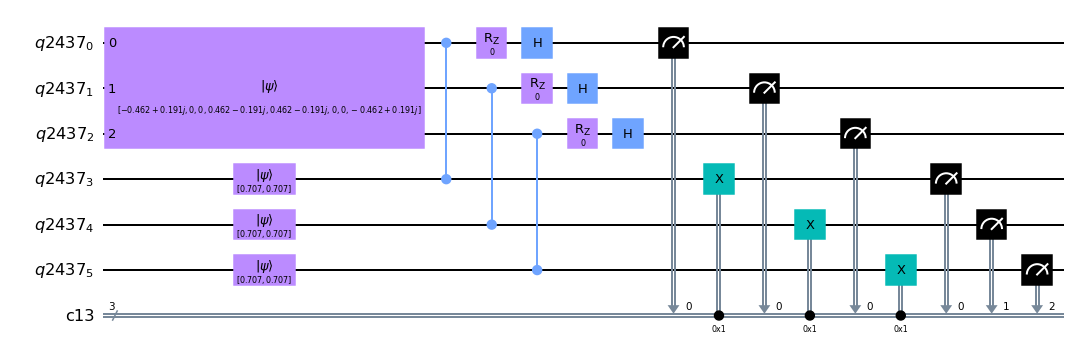

In [66]:
qc[-1].measure([3,4,5],[0,1,2])
qc[-1].draw('mpl')

In [18]:
counts_observed = execute(qc[-1], Aer.get_backend('qasm_simulator'), shots=10000).result().get_counts()

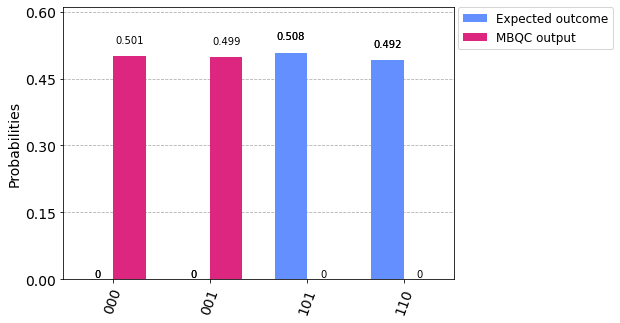

In [19]:
plot_histogram([counts_expected, counts_observed], legend=['Expected outcome', 'MBQC output'])

In [20]:
time_split_inst = []
t = 0
time_split_inst.append([])

for inst in parsed:
    if inst[0:4] != "qreg" and inst[0:4] != "creg":
        time_split_inst[t].append(inst);
        
        if(inst[0] == "c"):
            t += 1
            time_split_inst.append([])

NameError: name 'parsed' is not defined

In [24]:
for inst in time_split_inst:
    print(inst)


['h q[0]', 'cx q[0],q[1]']
['s q[0]', 'y q[0]', 'z q[1]', 'ry(-pi/4) q[2]', 'h q[2]', 'cz q[1],q[2]']
['x q[0]', 'measure q[0] -> c[0]', 'measure q[1] -> c[1]', 'measure q[2] -> c[2]']
